<h2> ToDo </h2>

- Fix Resize Factoring
- Fix File Reading
- Fix Extraneous Tensor Dimensions

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform
from PIL import Image
import numpy as np
import imageio
import skimage
import glob

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 500

print('using device:', device)

using device: cpu


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10
20
30
40
50
60
70
80
90
100


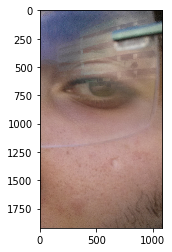

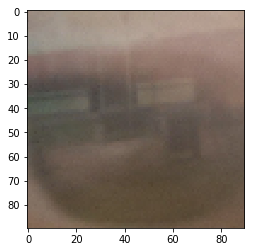

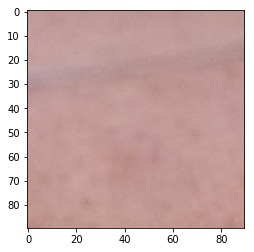

110
120
130
140
150
160
170
180
190
200


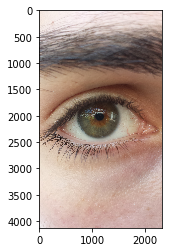

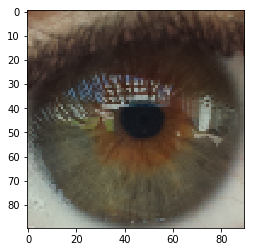

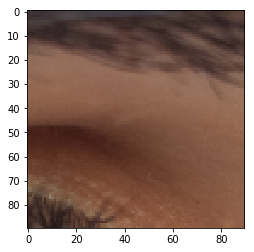

210
220
230
240
250
260
270
280
290
300


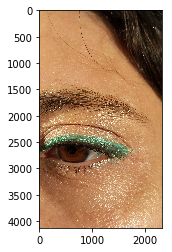

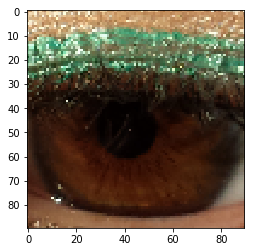

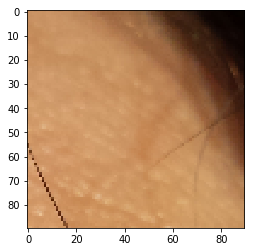

310
320
330
340
350
360
370
380
390
400


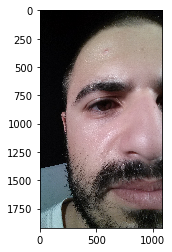

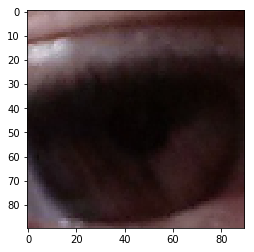

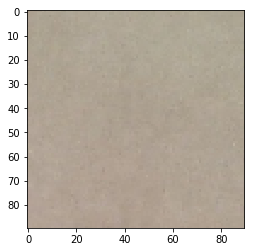

410
420
430
440
450
460
470
480
490
500


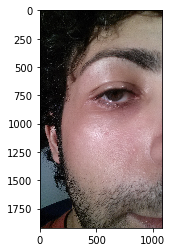

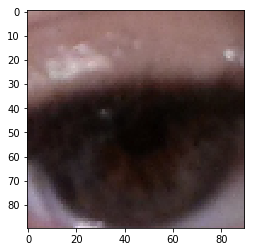

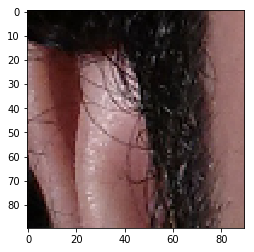

510
520
530
540
550
560
570
580
590
600


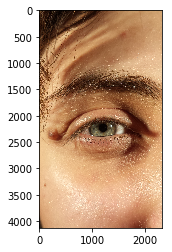

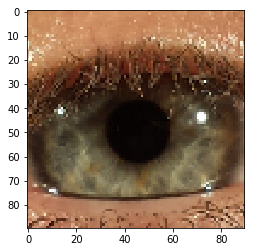

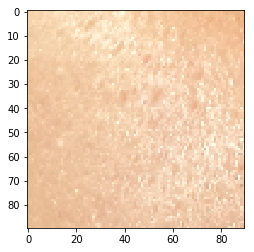

610
620
630
640
650
660
670
680
690
700


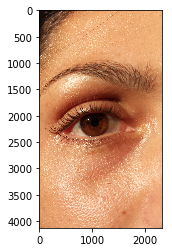

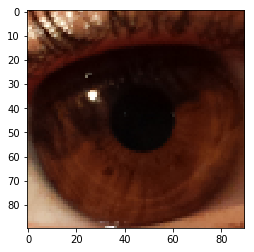

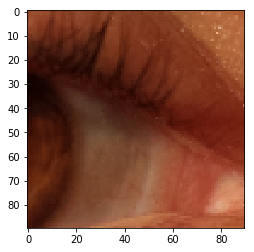

710
720
730
740
750
760
770
780
790
800


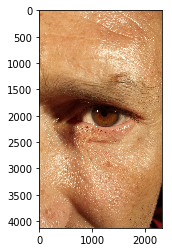

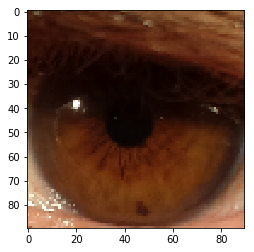

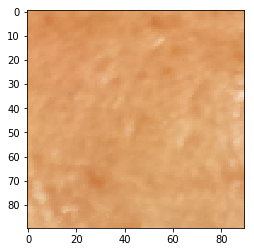

810
820
830
840
850
860
870
880
890
900


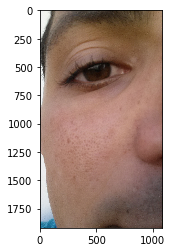

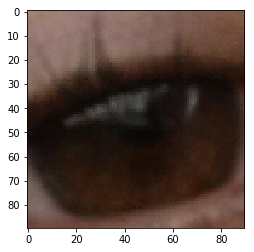

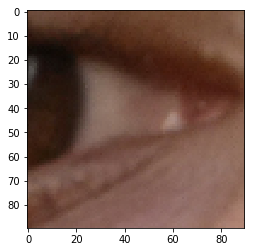

910
920
930
940
950
960
970
980
990
1000


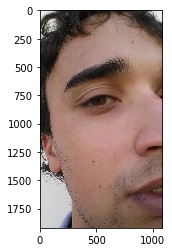

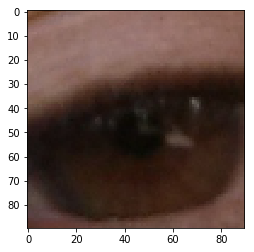

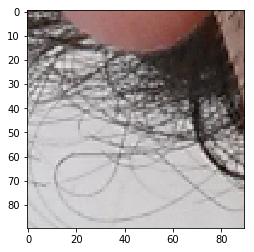

1010
1020
1030
1040
1050
1060
1070
1080
1090
1100


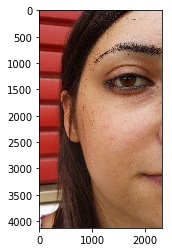

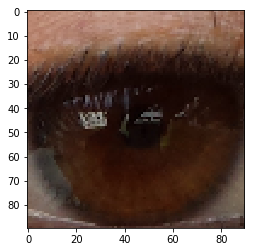

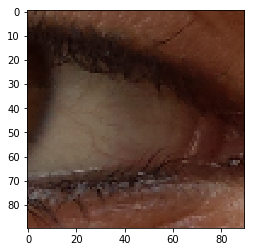

1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


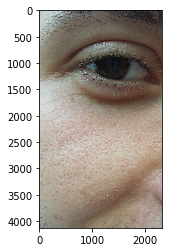

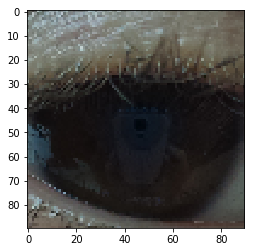

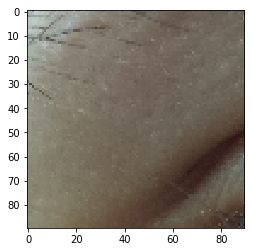

1210
1220
1230
1240
1250
1260
1270
1280
1290
(2594, 90, 90, 3)
(2594,)


In [28]:
def load_pics():
    
    X = []
    Y = []
    f = open('micheI_sgs4.txt')
    
    counter = 0
    for l in f:
        
        l = l.strip().split(' ')
        name, y, x, r = l[0], int(l[1]), int(l[2]), int(l[3])
        
        pic = imageio.imread('SamsungGalaxyS4/' + name + '.jpg')
        iris = pic[x-r:x+r,y-r:y+r,:]
        w, h, c = pic.shape
        
        corner_x = np.random.randint(0, w - 2*r)
        corner_y = np.random.randint(0, h - 2*r)
        while abs(corner_x - (x-r)) < r and abs(corner_y - (y-r)) < r:
            corner_x = np.random.randint(0, w - r)
            corner_y = np.random.randint(0, h - r)
        
        not_iris = pic[corner_x:corner_x+2*r, corner_y:corner_y+2*r,:]
        iris_scale = skimage.transform.resize(iris, (90,90,3))  
        not_iris_scale = skimage.transform.resize(not_iris, (90,90,3))
        X.append(iris_scale)
        X.append(not_iris_scale)
        Y.append(1)
        Y.append(0)
        
        counter += 1
        if counter % 10 == 0:
            print(counter)
           
        if counter % 100 == 0:
            plt.imshow(pic)
            plt.show()
            plt.imshow(iris_scale)
            plt.show()
            plt.imshow(not_iris_scale)
            plt.show()
    
    return (np.array(X), np.array(Y))

X, y = load_pics()
print(X.shape)
print(y.shape)

In [34]:
Xt = X.reshape((X.shape[0], 1, X.shape[3], X.shape[1], X.shape[2]))
yt = y.reshape((y.shape[0], 1))

In [35]:
N = Xt.shape[0]
train = int(6*N/10)
val = int(7*N/10)

X_train = Xt[:train]
X_val = Xt[train:val]
X_test = Xt[val:]

y_train = yt[:train]
y_val = yt[train:val]
y_test = yt[val:]

X_train = torch.tensor(X_train).type(torch.FloatTensor)
y_train = torch.tensor(y_train)

X_val = torch.tensor(X_val).type(torch.FloatTensor)
y_val = torch.tensor(y_val)

X_test = torch.tensor(X_test).type(torch.FloatTensor)
y_test = torch.tensor(y_test)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

torch.Size([1556, 1, 3, 90, 90])
torch.Size([1556, 1])
torch.Size([259, 1, 3, 90, 90])
torch.Size([259, 1])
torch.Size([779, 1, 3, 90, 90])
torch.Size([779, 1])


In [36]:
def check_accuracy_part34(mode, model, new_x = None, new_y = None):
            
    if mode == 'val':
        X_sel = X_val
        y_sel = y_val
    elif mode == 'train':
        X_sel = X_train
        y_sel = y_train
    elif mode == 'test':
        X_sel = X_test
        y_sel = y_test
    else:
        X_sel = new_x
        y_sel = new_y
        
        
    SE = 0.0
    num_correct = 0
    num_samples = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t in range(X_sel.shape[0]):
            
            x = X_sel[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            #x_center = model(x)
            #SE += (x_center.data[0][0] - y) ** 2
            
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f) for mode %s' % (num_correct, num_samples, 100 * acc, mode))
        #print(('RMSE ->', SE))

In [37]:
def train_part34(model, optimizer, epochs=20):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        #for t, (x, y) in enumerate(training_data):
        for t in range(X_train.shape[0]):
            model.train()  # put model to training mode
            
            x = X_train[t]
            y = y_train[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            #x_center = model(x)
            #loss = F.mse_loss(x_center[0][0], y)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print() 
        
        print('epoch %d' % (e))
        check_accuracy_part34('train', model)
        check_accuracy_part34('val', model)
        print() 

In [38]:
def flatten(x):
    return x.view(x.shape[0] , -1)

In [39]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [43]:
channel_1 = 32
channel_2 = 16

model = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(7056, 672),
    nn.ReLU(),
    nn.Linear(672, 2)
)

optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, nesterov=True)

In [44]:
print('Train Iris')
train_part34(model, optimizer, epochs=10)

Train Iris
Iteration 0, loss = 0.6740

Iteration 500, loss = 0.5772

Iteration 1000, loss = 0.0686

Iteration 1500, loss = 0.0217

epoch 0
Got 1399 / 1556 correct (89.91) for mode train
Got 236 / 259 correct (91.12) for mode val

Iteration 0, loss = 0.1335

Iteration 500, loss = 0.6020

Iteration 1000, loss = 0.0183

Iteration 1500, loss = 0.0105

epoch 1
Got 1434 / 1556 correct (92.16) for mode train
Got 250 / 259 correct (96.53) for mode val

Iteration 0, loss = 0.0040

Iteration 500, loss = 0.6293

Iteration 1000, loss = 0.0129

Iteration 1500, loss = 0.0049

epoch 2
Got 1434 / 1556 correct (92.16) for mode train
Got 248 / 259 correct (95.75) for mode val

Iteration 0, loss = 0.0005

Iteration 500, loss = 0.4510

Iteration 1000, loss = 0.0134

Iteration 1500, loss = 0.0019

epoch 3
Got 1454 / 1556 correct (93.44) for mode train
Got 249 / 259 correct (96.14) for mode val

Iteration 0, loss = 0.0001

Iteration 500, loss = 0.2122

Iteration 1000, loss = 0.0186

Iteration 1500, loss = 0

In [47]:
check_accuracy_part34('test', model)

Got 753 / 779 correct (96.66) for mode test


(1247, 2071, 297, 4128, 2322, 3)


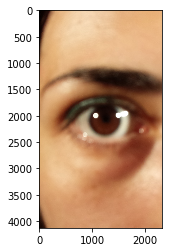

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(0, 0)
(0, 10)
(0, 20)
(0, 30)
(0, 40)
(0, 50)
(0, 60)
(10, 0)
(10, 10)
(10, 20)
(10, 30)
(10, 40)
(10, 50)
(10, 60)
(20, 0)
(20, 10)
(20, 20)
(20, 30)
(20, 40)
(20, 50)
(20, 60)
(30, 0)
(30, 10)
(30, 20)
(30, 30)
(30, 40)
(30, 50)
(30, 60)
(40, 0)
(40, 10)
(40, 20)
(40, 30)
(40, 40)
(40, 50)
(40, 60)
(50, 0)
(50, 10)
(50, 20)
(50, 30)
(50, 40)
(50, 50)
(50, 60)
(60, 0)
(60, 10)
(60, 20)
(60, 30)
(60, 40)
(60, 50)
(60, 60)
(70, 0)
(70, 10)
(70, 20)
(70, 30)
(70, 40)
(70, 50)
(70, 60)
(80, 0)
(80, 10)
(80, 20)
(80, 30)
(80, 40)
(80, 50)
(80, 60)
(90, 0)
(90, 10)
(90, 20)
(90, 30)
(90, 40)
(90, 50)
(90, 60)
(100, 0)
(100, 10)
(100, 20)
(100, 30)
(100, 40)
(100, 50)
(100, 60)
(110, 0)
(110, 10)
(110, 20)
(110, 30)
(110, 40)
(110, 50)
(110, 60)
(120, 0)
(120, 10)
(120, 20)
(120, 30)
(120, 40)
(120, 50)
(120, 60)
(130, 0)
(130, 10)
(130, 20)
(130, 30)
(130, 40)
(130, 50)
(130, 60)
(140, 0)
(140, 10)
(140, 20)
(140, 30)
(140, 40)
(140, 50)
(140, 60)


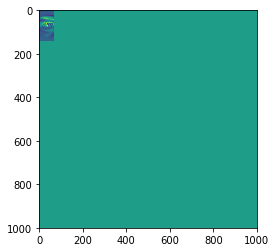

In [86]:
f = open('micheI_sgs4.txt')
for bs in range(20):
    l = f.readline()

l = l.strip().split(' ')
name, y, x, r = l[0], int(l[1]), int(l[2]), int(l[3])   
pic = imageio.imread('SamsungGalaxyS4/' + name + '.jpg')
w, h, c = pic.shape
print((y, x, r, w, h, c))
plt.imshow(pic)
plt.show()

scores = np.zeros((1000,1000))
icount = 0
jcount = 0
for ic, i in enumerate(range(0, w-2*r, 25)):
    for jc, j in enumerate(range(0, h-2*r, 25)):
        model_in = skimage.transform.resize(pic[i:i+2*r,j:j+2*r,:], (90,90,3))
        score = model(torch.tensor(model_in.reshape((1, 3, 90, 90))).type(torch.FloatTensor))
        score_np = np.array(score.detach())
        scores[ic,jc] = score_np[0,1] - score_np[0,0]   
        if ic % 10 == 0 and jc % 10 == 0:
            print((ic,jc))
            
'''
        subset.append()

subset = np.array(subset)
print(subset.shape)
subsett = subset.reshape((subset.shape[0], subset.shape[3], subset.shape[1], subset.shape[2]))
subsett = torch.tensor(subsett).type(torch.FloatTensor)
print(subsett.shape)
scores1 = np.array(model(subsett).detach())[:,1].reshape(icount, jcount)
scores0 = np.array(model(subsett).detach())[:,0].reshape(icount, jcount)
'''


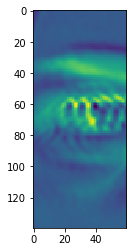

In [87]:

plt.imshow(scores[0:140,0:60])
plt.show()